$\large{\textbf{Markov Chain Monte Carlo (MCMC) Algorithms}}$

While I was learning about MCMC algorithms, I found it hard to understand them by just reading papers and tutorials. Hence, I coded up some examples to show both the motivations and the implementations of these algorithms.

In [1]:
%matplotlib inline

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

MCMC algorithms are algorithms that samples from complex probability distributions. They are commonly used when it is difficult or impossible to directly sample from a target probability distribution. In this notebook, I will implement 2 common MCMC algorithms, namely the Metropolis-Hastings algorithm and Gibbs sampling.

An example of one such scenario would sampling from posterior distributions, 

<center>$\large{p(\theta | x) = \frac{p(x, \theta)p(\theta)}{p(x)}}$</center>

Due to the $p(x)$ term, the posterior may be difficult to sample from. For non-trivial models, it is extremely difficult to calculate this integral, $\int_{\Theta}^{} p(x, \theta) d\theta = p(x)$. I will first show an example of this problem being solved analytically, then I will demonstrate how the Metropolis-Hastings algorithm can be used in the more general case where there is no closed-form solution to the posterior distribution.

Suppose we have a set of data points $x_i \in X$, which are normally distributed given its mean, $\mu$ such that $x_i | \mu \sim N(\mu, \sigma)$, where its mean also follows a normal distribution such that $\mu \sim N(M, \tau)$. Since both the likelihood and prior are normally distributed, we are able to compute the parameters of the posterior analytically. Details of the full mathematical derivation can be found from [here](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxiYXllc2VjdHxneDplNGY0MDljNDA5MGYxYTM). In the 2 cells that follow, I replicate the data and the results that are shown in the link.

True value of mu: 68.5955421485


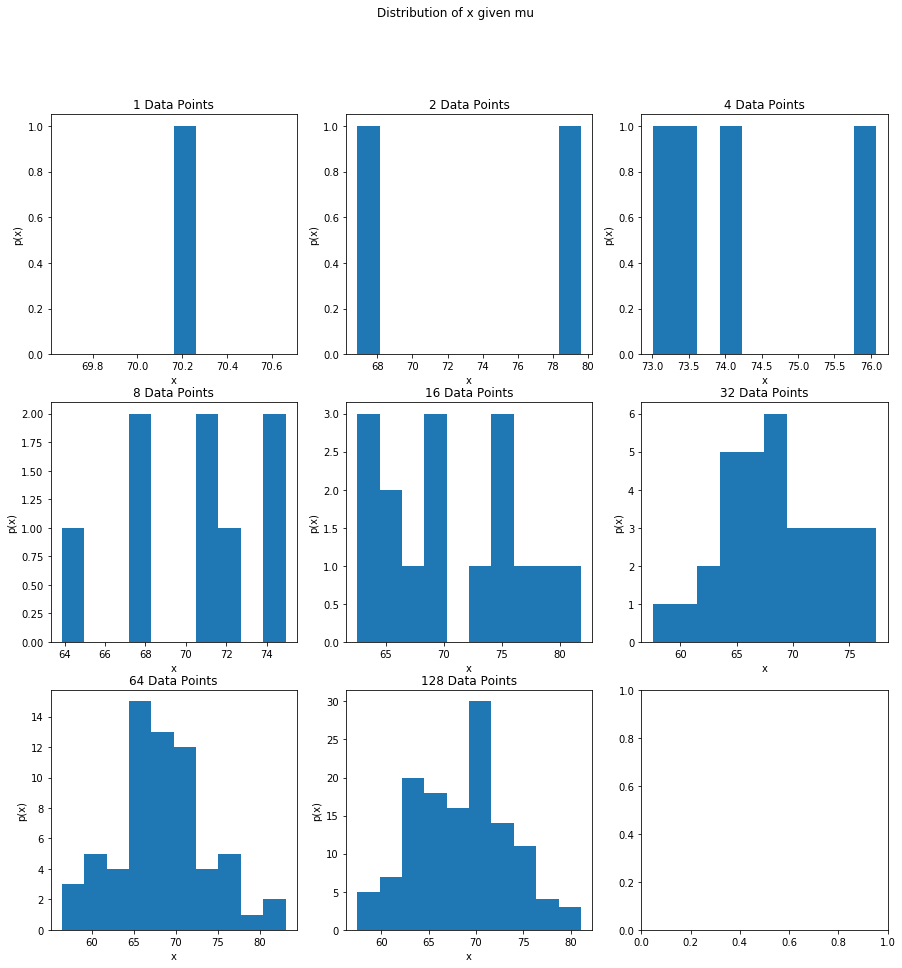

In [2]:
M = 60
tau = 10
mu = np.random.normal(loc=M, scale=tau, size=1)[0]
sigma = 5
num_x = [1, 2, 4, 8, 16, 32, 64, 128]

print("True value of mu:", mu)

x_vals = []
fig, axes = plt.subplots(3,3,figsize=(15,15))
plt.suptitle('Distribution of x given mu')
for idx, val in enumerate(num_x):
    x = np.random.normal(loc=mu, scale=sigma, size=val)
    x_vals.append(x)
    
    axes[idx // 3, idx % 3].hist(x)
    axes[idx // 3, idx % 3].set(xlabel='x', ylabel='p(x)', title=str(val) + ' Data Points');

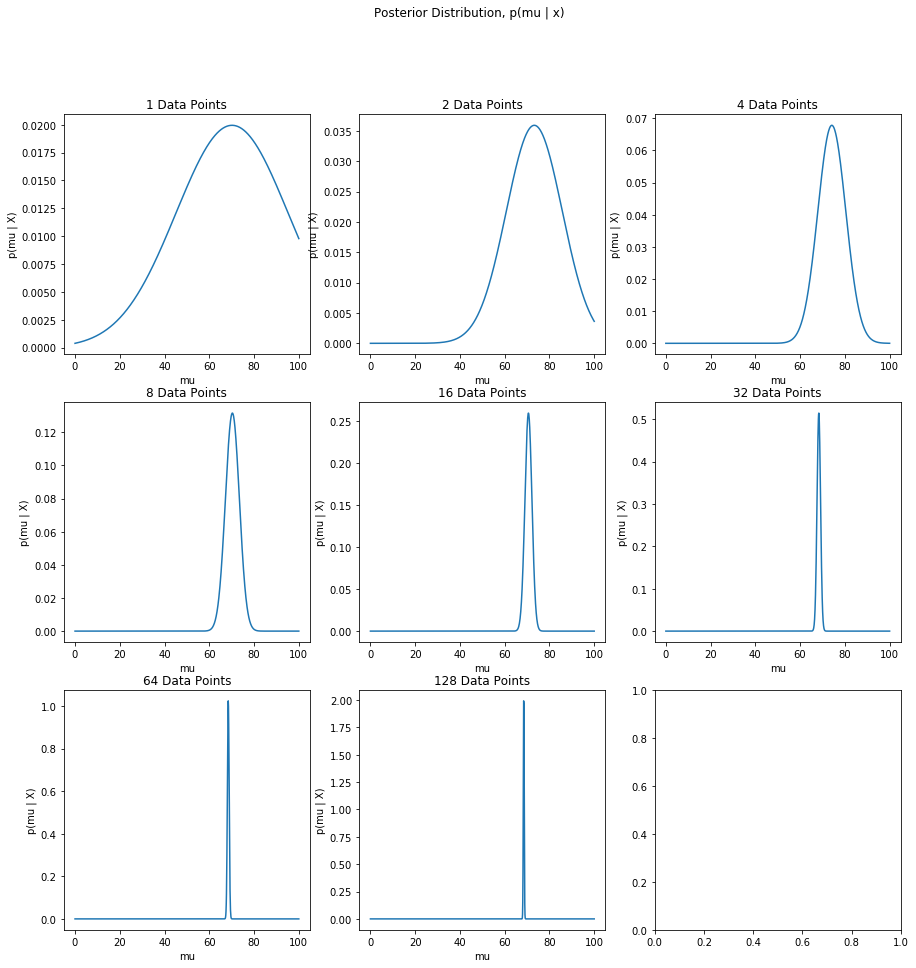

In [3]:
fig1, axes1 = plt.subplots(3,3,figsize=(15,15))
plt.suptitle('Posterior Distribution, p(mu | x)')

for idx, val in enumerate(x_vals):
    x_mu = np.mean(val)
    possible_mu = np.linspace(0, 100, num=1000)
    posterior_mu = ((sigma**2)*possible_mu + num_x[idx]*(tau**2)*x_mu)/(num_x[idx]*(tau**2) + sigma**2)
    posterior_sigma = ((sigma**2)*(tau**2)/(num_x[idx]*(tau**2) + sigma**2))
    mu_pdf = norm.pdf(possible_mu, loc=posterior_mu, scale=posterior_sigma)

    axes1[idx // 3, idx % 3].plot(possible_mu, mu_pdf)
    axes1[idx // 3, idx % 3].set(xlabel='mu', ylabel='p(mu | X)', title=str(num_x[idx]) + ' Data Points')

For the sake of demostration, let us now assume that there is no closed-form analytical solution for the posterior distribution. In this case, if we still want to sample from this distribution, we can make use of the Metropolis-Hastings algorithm.

The algorithm is pretty simple. For $T$ transitions:

1. Generate $Y_t \sim q(y|x^{(t)})$
2. Take $   
X^{(t+1)} = 
     \begin{cases}
       Y_t\text{,} &\quad\text{with probability } \rho(x^{(t)}, Y_t) \text{,}\\
       x^{(t)}\text{,} &\quad\text{with probability } 1 - \rho(x^{(t)}, Y_t) \text{,}\\
     \end{cases}$ where $\rho(x, y) = min\{\frac{\tilde{\pi}(y)}{\tilde{\pi}(x)}\frac{q(x | y)}{q(y | x)}, 1\}$
     
The transitions made by the Markov Chain $(X^{(t)})$ shown in this algorithm preserves the stationary density $\pi$, which is also the target density, $p(\mu | x)$ we want to sample from. The conditional density here $q$ is also called a $\textit{proposal}$ or a $\textit{candidate kernel}$. In order to generate accurate samples without too many transitions, the arbitrary proposal density $q$ should be chosen such that its support wide enough to eventually reach any region of the state space $\chi$ with positive mass under $\pi$.

In this particular demostration, I have chosen $q(x|y)$ such that $x \sim N(y, \alpha)$ where $\alpha$ is a tuneable parameter that would affect the rate at which the Markov Chain converges. Hence, in our example problem, the term $\rho(x^{(t)}, Y_t) = \frac{\tilde{\pi}(Y_t)}{\tilde{\pi}(x^{(t)})}\frac{q(x^{(t)} | Y_t)}{q(Y_t | x^{(t)})}$ can be reduced to $\frac{p(\mu | X)}{p(\mu_0 | X)}\frac{q(\mu_0 | \mu)}{q(\mu | \mu_0)} = \frac{p(X | \mu)p(\mu)}{p(X | \mu_0)p(\mu_0)}\frac{q(\mu_0 | \mu)}{q(\mu | \mu_0)}$. $X$ is the set of data points first generated, $\mu$ is the value generated by the proposal kernel and $\mu$ is the latest value in the Markov Chain.

In the code below, I ran the algorithm over $T$ timesteps and used $\alpha$ = 2.5.

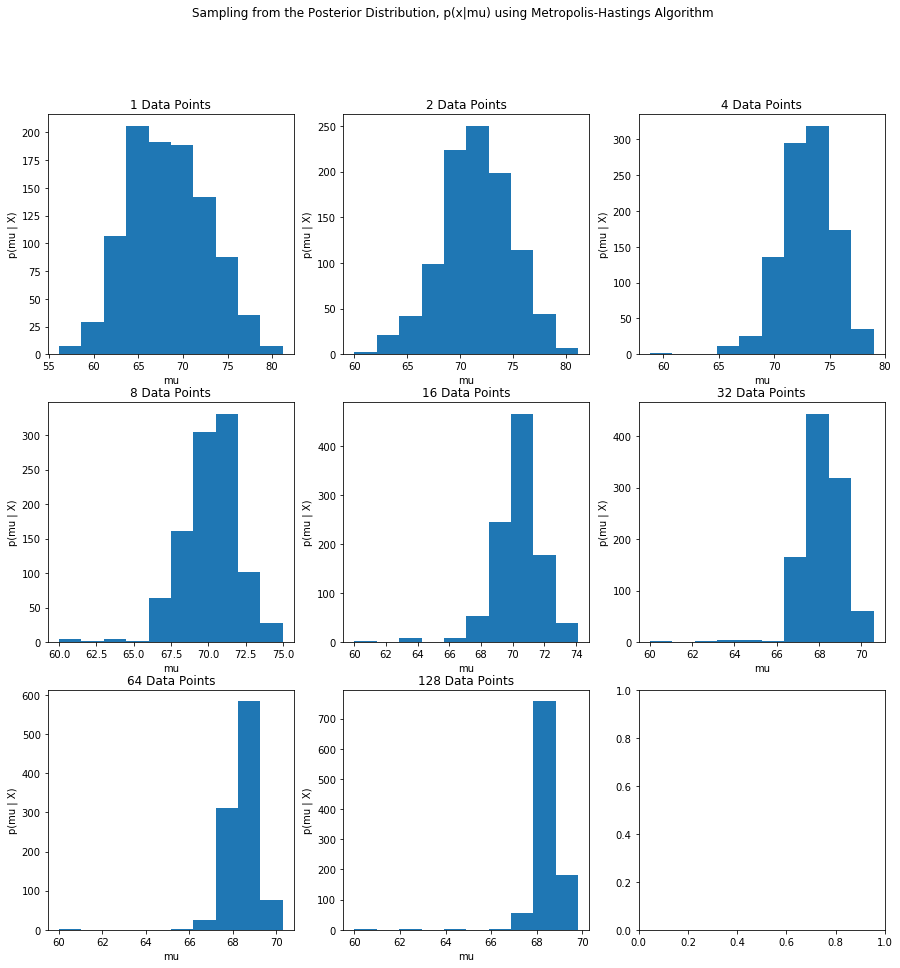

In [4]:
T = 1000
alpha = 2.5
fig2, axes2 = plt.subplots(3,3,figsize=(15,15))
plt.suptitle('Sampling from the Posterior Distribution, p(x|mu) using Metropolis-Hastings Algorithm')

for idx, val in enumerate(x_vals):
    posterior_dist_MH = [M]
    for i in range(T):
        current_mu = posterior_dist_MH[-1]
        proposal = np.random.normal(loc=current_mu, scale=alpha)

        current_prob = norm(current_mu, sigma).pdf(val).prod()*norm(M, tau).pdf(current_mu)
        proposal_prob = norm(proposal, sigma).pdf(val).prod()*norm(M, tau).pdf(proposal)
        accept_prob = min(proposal_prob/current_prob, 1)
        
        if np.random.rand() < accept_prob:
            posterior_dist_MH.append(proposal)
        else:
            posterior_dist_MH.append(current_mu)
            
    axes2[idx // 3, idx % 3].hist(posterior_dist_MH)
    axes2[idx // 3, idx % 3].set(xlabel='mu', ylabel='p(mu | X)', title=str(num_x[idx]) + ' Data Points')

One key learning point for me is that while $q$ can be any arbitrary conditional density, you should pick one that would generate samples close to values that can be sampled from $p(\mu | X)$. As we have many data points, if you generate a candidate value $\mu$ such that $p(\mu | X) = p(X | \mu)p(\mu) = \prod_{i=1}^{n}p(x_i | \mu)p(\mu)$ is close to zero, then the Markov Chain would never choose the generated value and the algorithm would not work well.

When dealing with multivariate probabilities distributions, one might choose to use Gibbs sampling. However, Gibbs sampling requires us to have knowledge about the conditional probability distributions (in this case $p(x_1 | x_2)$ and $p(x_2 | x_1)$). In most case, Gibbs sampling is chosen when the joint probability distributions are much more difficult to sample from than the conditional probability distributions. Potential areas of applications might be to sample from posterior distributions of Bayesian Networks.

The Gibbs sampling algorithm is pretty similar to that of Metropolis-Hasting algorithm:
1. Initialize $x^{(0)} \sim q(x)$
2. For $T$ transitions: $x_i^{(t)} \sim p(x_i | x_1^{(t-1)}, x_2^{(t-1)}, ...,x_{i-1}^{(t-1)}, x_{i+1}^{(t-1)}, x_D^{(t-1)})$ for $i = 0, 1, ..., D$ for a D-dimensional probability distribution.

In the example below, I will demonstrate Gibbs sampling by sampling from a bivariate Gaussian distribution. The mathematical derivations of the conditional probability distributions can be found in this link [here](http://fourier.eng.hmc.edu/e161/lectures/gaussianprocess/node7.html). I also included a "burn in" period of 100 time steps. They are earlier iterations of the algorithms which are not sampled from the target distribution as the Markov Chains takes some time to converge to the stationary distribution.

Mean Vector:  [ 69.11572376  52.85830548]
Covariance Matrix:  [[1, 0.32924297315006579], [0.32924297315006579, 1]]


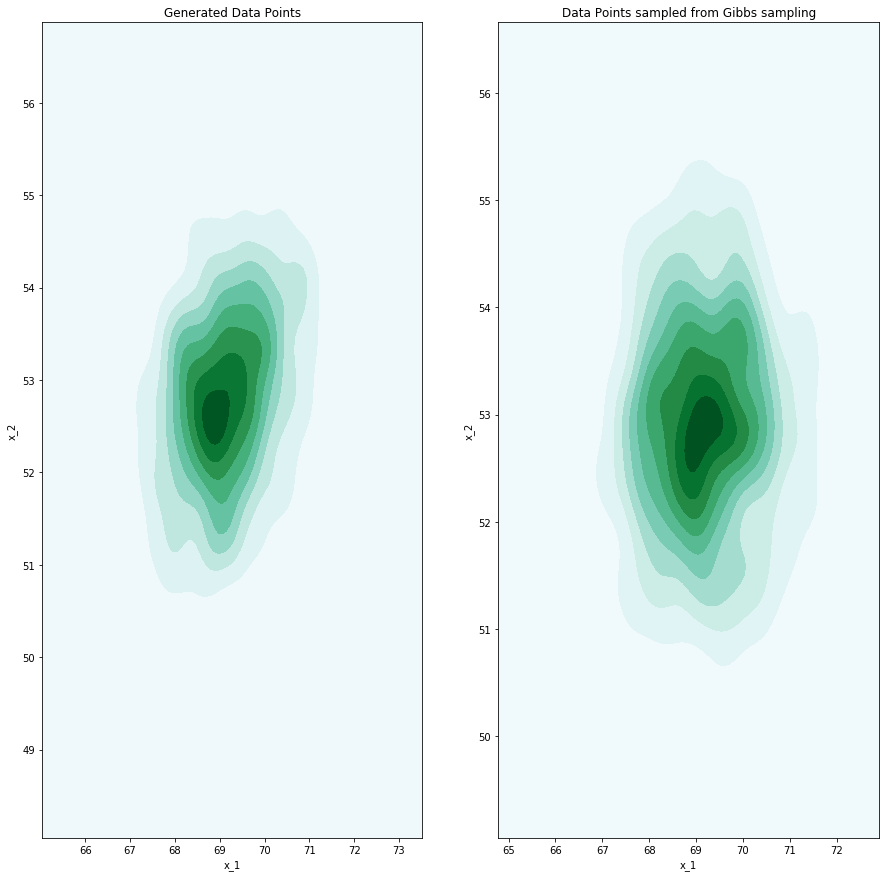

In [5]:
T = 1100

cov_cross = np.random.uniform(size=1)[0]
mu_mult = np.random.normal(loc=M, scale=tau, size=2)
cov_mult = [[1, cov_cross], [cov_cross, 1]]
x1_mult, x2_mult = np.random.multivariate_normal(mu_mult, cov_mult, 1000).T
print("Mean Vector: ", mu_mult)
print("Covariance Matrix: ", cov_mult)

fig3, axes3 = plt.subplots(1,2,figsize=(15,15));
sns.kdeplot(x1_mult, x2_mult, shade=True, ax=axes3[0]);
axes3[0].set(xlabel='x_1', ylabel='x_2', title='Generated Data Points');

posterior_dist_Gibbs_x1 = [np.mean(x1_mult)]
posterior_dist_Gibbs_x2 = [np.mean(x2_mult)]

for i in range(T):
    current_x1_mu = mu_mult[0] + cov_cross*(posterior_dist_Gibbs_x2[-1] - mu_mult[1])
    current_x1_sigma = (1 - cov_cross**2)**0.5
    proposed_x1 = np.random.normal(loc=current_x1_mu, scale=current_x1_sigma)
    
    current_x2_mu = mu_mult[1] + cov_cross*(posterior_dist_Gibbs_x1[-1] - mu_mult[0])
    current_x2_sigma = (1 - cov_cross**2)**0.5
    proposed_x2 = np.random.normal(loc=current_x2_mu, scale=current_x2_sigma)
    
    posterior_dist_Gibbs_x1.append(proposed_x1)
    posterior_dist_Gibbs_x2.append(proposed_x2)

    
sns.kdeplot(np.asarray(posterior_dist_Gibbs_x1[100:]), np.asarray(posterior_dist_Gibbs_x2[100:]), shade=True, ax=axes3[1]);
axes3[1].set(xlabel='x_1', ylabel='x_2', title='Data Points sampled from Gibbs sampling');